<a href="https://colab.research.google.com/github/rheopy/rheofit/blob/master/notebooks/composite_models/HS_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/rheopy/rheofit.git

  Cloning https://github.com/rheopy/rheofit.git to /tmp/pip-req-build-j4_zkgu8
  Running command git clone -q https://github.com/rheopy/rheofit.git /tmp/pip-req-build-j4_zkgu8
     |████████████████████████████████| 266kB 2.8MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 215kB 8.7MB/s 
     |████████████████████████████████| 256kB 11.5MB/s 
  Created wheel for rheofit: filename=rheofit-0.1.0-cp36-none-any.whl size=9868 sha256=94cfe988c62aaae364da1f6f9583c266a710f681cd0f2972a6a381641c7c08ab
  Stored in directory: /tmp/pip-ephem-wheel-cache-ldps8byt/wheels/a4/58/61/22fb357c158d287fa7e6b6a2b1cc7379d68d1d40fdbb8daf64
  Created wheel for lmfit: filename=lmfit-1.0.1-cp36-none-any.whl size=81991 sha256=ca493cbfba3a29202e1cb76f319ee5b7e112e8effdd07b057747aa0fdc41734b
  Stored in directory: /root/.cache/pip/wheels/ef/22/8d/6cd9c0af36f501cfb248673b05dad5d2c27504951d55519acb
  Created wheel for asteval: filename=asteval-0.9.19-cp36-none-any.whl

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from IPython.display import Math

import rheofit
import pybroom as pb
import corner

import seaborn as sns

In [3]:

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [4]:
!git clone https://github.com/rheopy/rheofit.git

Cloning into 'rheofit'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 432 (delta 104), reused 31 (delta 14), pack-reused 228
Receiving objects: 100% (432/432), 2.93 MiB | 3.76 MiB/s, done.
Resolving deltas: 100% (239/239), done.


# Model system: Hard spheres in worm like micelles

60% w/w 5um diameter polystirene particles

10% LAS surfactant solution



In [5]:
#importing data from trios exported excel file
#importing 3rd step in the procedure

data_folder='./rheofit/notebooks/data/'

data_file_list=['HS60_10las_full_15.xls',
                'HS60_10las_full_30.xls',
                'HS60_10las_full_40.xls',
                'HS60_10las_full_50.xls']


data_dict={}
for filename in data_file_list:
    data_dict[filename]=pd.read_excel(f'{data_folder}/{filename}',sheet_name=3,skiprows=[0,2])

The model is a combination of Three component model:

$$ \sigma = \sigma_y + \sigma_y\cdot(\dot\gamma/\dot\gamma_{c_{TC}})^{0.5} + \dot\gamma \cdot \eta_{bg}$$

and the Carreau model:

$$ \sigma = \dot\gamma \cdot \eta_{bg} \cdot (1+(\dot\gamma/\dot\gamma_{c_{carreau}})^2)^{-0.5}$$

* The three component model: decribes the attactive gel/glass formed by the polystirene particles attracted to each other by the depletion interaction caused by the presence of worm like micelles. In this case the Newtonian term in the model is removed and replaced by ...
* The carreau model: describes the worm like micellar solution with a constant viscosity at low shear and a shear thinning region above a critical shear rate. To indicate the presence of a stress plateau in the shear thinning region we fixed the exponent of the Carreau model to 0.

The composite model is:

$$ \sigma = \sigma_y + \sigma_y\cdot(\dot\gamma/\dot\gamma_{c_{TC}})^{0.5} + \dot\gamma \cdot \eta_{bg} \cdot (1+(\dot\gamma/\dot\gamma_{c_{carreau}})^2)^{-0.5}$$

$$ \sigma_{plateau}=\eta_{bg} \cdot \dot\gamma_{c_{carreau}}$$

We also defined the stress plateau as the product of the background viscosity term time the Carreau critical shear rate. This quantity can be considered a material property linked to the surfactant solution and do not vary as a function of temperature.

The resulting composite model which we refer to as TCC (three component carreau) has 4 free parameters which can be reduced to three by an independent measurement of the surfactant solution stress plateu value.


In [6]:
TCn=rheofit.models.TCn_model
TCn.set_param_hint('TCn_eta_bg', value=0, vary=False)
TCn.set_param_hint('TCn_n', value=0.5, vary=False)

carreau=rheofit.models.carreau_model
carreau.set_param_hint('carreau_n',value=0, vary=False)
model=TCn+carreau

In [7]:
par_wid=rheofit.visualization.make_par_widget(model,data_dict[data_file_list[0]])

In [8]:
params=rheofit.visualization.make_par_from_widget(par_wid)

params.add('carreau_stress_plateau', value=250, min=0, vary=False)
params.add('carreau_eta_0', expr='carreau_stress_plateau/carreau_gammadot_crit')
params

name,value,initial value,min,max,vary,expression
TCn_ystress,1.5335e-04,0.0001533462377310002,0.00000000,inf,True,
TCn_eta_bg,0.00000000,0.0,0.00000000,inf,False,
TCn_gammadot_crit,1.3056e-08,1.3056278502787677e-08,0.00000000,inf,True,
TCn_n,0.50000000,0.5,0.00000000,1.00000000,False,
carreau_eta_0,7.76961845,None,-inf,inf,False,carreau_stress_plateau/carreau_gammadot_crit
carreau_gammadot_crit,32.1766122,32.176612205970976,0.00000000,inf,True,
carreau_n,0.00000000,0.0,0.00000000,1.00000000,False,
carreau_stress_plateau,250.000000,250,0.00000000,inf,False,


We fit the flow curve data obtained at different temperature of 15C, 20C, 30C, 40C, 50C and we obtain the results reported in the plots below. 

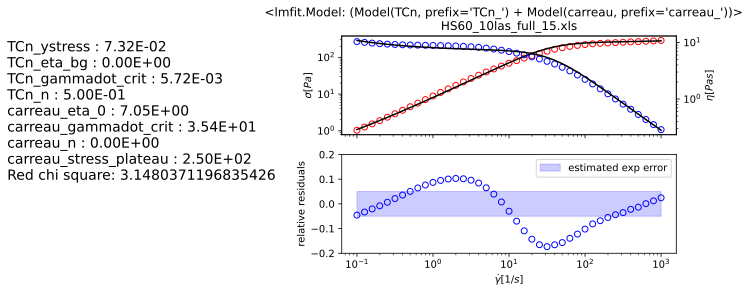

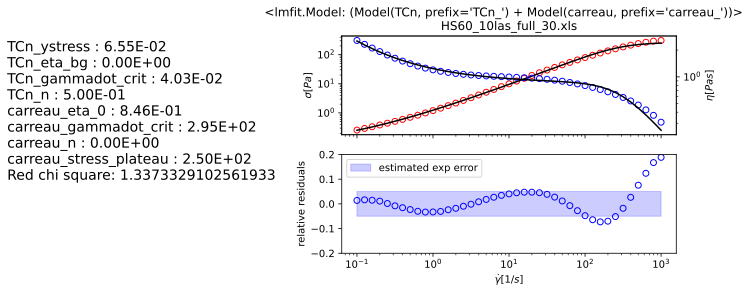

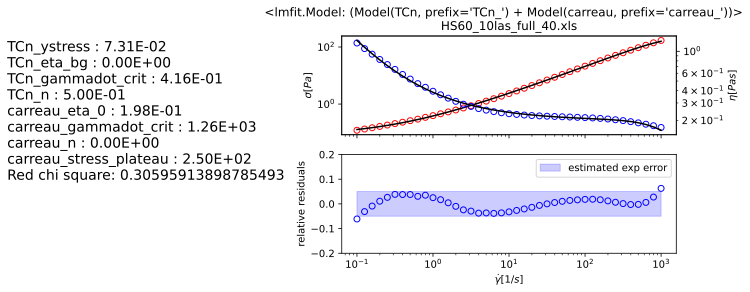

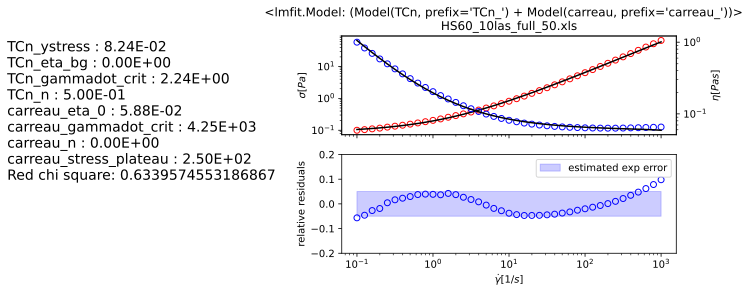

In [9]:
fit_res_dict={}

min_shear_rate=0.001
max_shear_rate=10000

for filename, data in data_dict.items():
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)    
    fit_res=model.fit(data['Stress'],x=data['Shear rate'],params=params,
                                     weights=1/(0.05*data[mask]['Stress']),
                                     nan_policy='omit')
    fit_res_dict[filename]=fit_res
    rheofit.visualization.update_par_widget(par_wid,fit_res)
    
for filename,fit_res in fit_res_dict.items():
    rheofit.visualization.plot_fit_res(fit_res, show_par_values=True);
    plt.title(filename)

In [ ]:
table_result=pb.tidy(fit_res_dict)
table_result.pivot(index='key', columns='name', values='value')

name,TCn_eta_bg,TCn_gammadot_crit,TCn_n,TCn_ystress,carreau_eta_0,carreau_gammadot_crit,carreau_n,carreau_stress_plateau
key,,,,,,,,
HS60_10las_full_15.xls,0.0,0.005724,0.5,0.073187,7.053373,35.444035,0.0,250.0
HS60_10las_full_30.xls,0.0,0.040274,0.5,0.065492,0.846465,295.345953,0.0,250.0
HS60_10las_full_40.xls,0.0,0.416225,0.5,0.073149,0.197939,1263.018045,0.0,250.0
HS60_10las_full_50.xls,0.0,2.241467,0.5,0.082405,0.058819,4250.318606,0.0,250.0


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set(**kwargs)


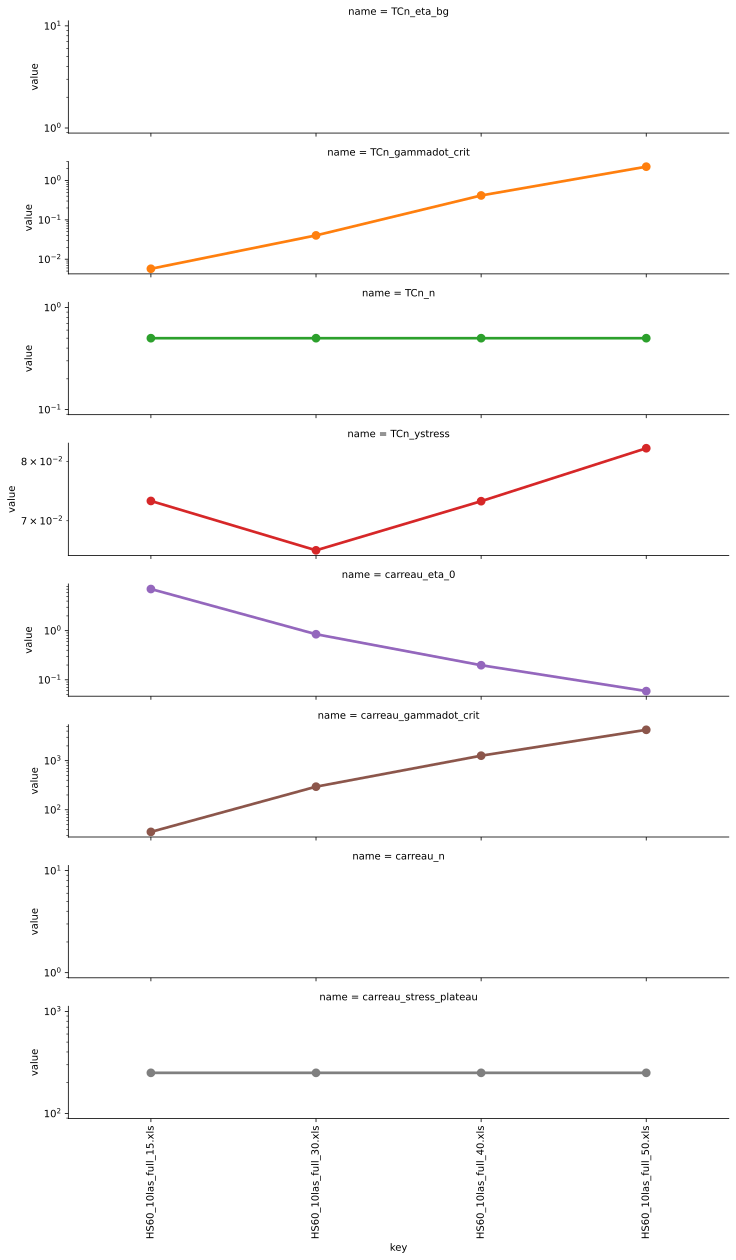

In [ ]:
g = sns.catplot(x="key", y="value",
                hue="name", row="name",
                data=pb.tidy(fit_res_dict), kind="point",
                dodge=False,
                sharey=False,
                height=2, aspect=5).set_xticklabels(rotation=90).set(yscale="log")

/usr/local/lib/python3.6/dist-packages/lmfit/model.py:1499: RuntimeWarning: invalid value encountered in add
  df2 += fjac[i]*fjac[j]*covar[i, j]


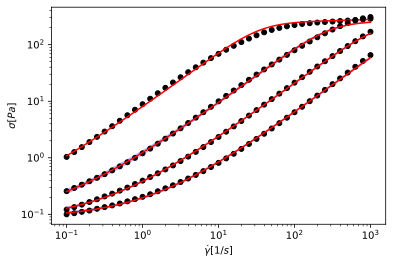

In [ ]:
for filename, fit_res in fit_res_dict.items():
    rheofit.visualization.plot_confidence(fit_res,expand=1)

In [21]:
#importing data from trios exported excel file
#importing 3rd step in the procedure

data_folder='./rheofit/notebooks/data/'

data_file_list_solvent=['las10_15_full.xls',
                'las10_20_full.xls',
                'las10_30_full.xls',
                'las10_40_full.xls']


data_dict_solvent={}
for filename in data_file_list_solvent:
    data_dict_solvent[filename]=pd.read_excel(f'{data_folder}/{filename}',sheet_name=3,skiprows=[0,2])

In [23]:
carreau=rheofit.models.carreau_model
carreau.set_param_hint('carreau_n',value=0, vary=False)
model_solvent=carreau

In [27]:
par_wid_solvent=rheofit.visualization.make_par_widget(model_solvent,data_dict_solvent[data_file_list_solvent[0]])

In [33]:
params=rheofit.visualization.make_par_from_widget(par_wid_solvent)

params.add('carreau_stress_plateau', value=180, min=0, vary=False)
params.add('carreau_eta_0', expr='carreau_stress_plateau/carreau_gammadot_crit')
params

name,value,initial value,min,max,vary,expression
carreau_eta_0,3.34918587,None,-inf,inf,False,carreau_stress_plateau/carreau_gammadot_crit
carreau_gammadot_crit,53.7444045,53.74440453732464,0.00000000,inf,True,
carreau_n,0.00000000,0.0,0.00000000,1.00000000,False,
carreau_stress_plateau,180.000000,180,0.00000000,inf,False,


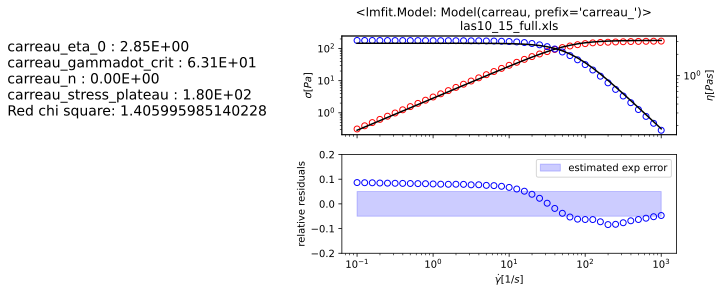

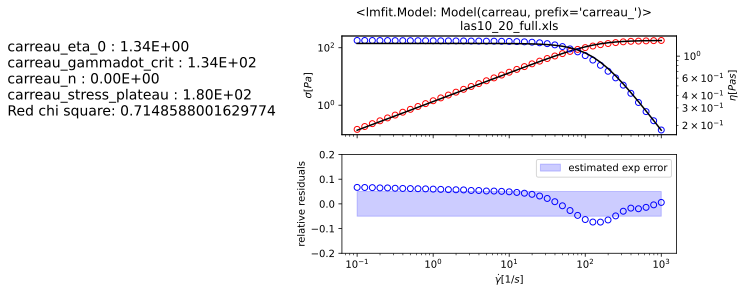

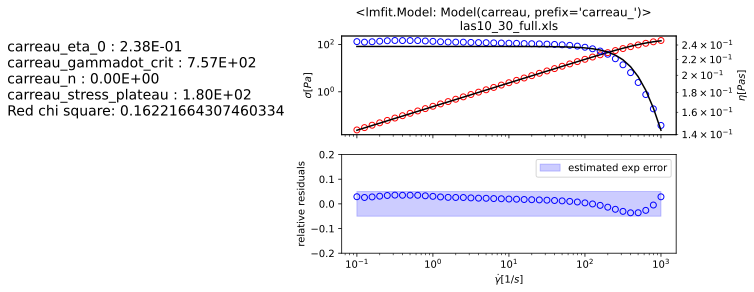

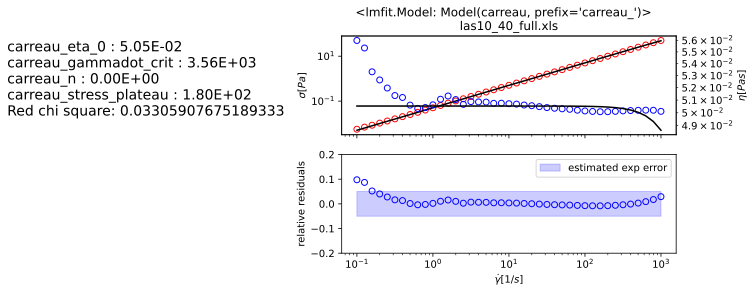

In [37]:
fit_res_dict_solvent={}

min_shear_rate=10
max_shear_rate=10000

for filename, data in data_dict_solvent.items():
    mask=(data['Shear rate']>=min_shear_rate) & (data['Shear rate']<=max_shear_rate)    
    fit_res=model_solvent.fit(data['Stress'],x=data['Shear rate'],params=params,
                                     weights=1/(0.05*data[mask]['Stress']),
                                     nan_policy='omit')
    fit_res_dict_solvent[filename]=fit_res
    
    
for filename,fit_res in fit_res_dict_solvent.items():
    rheofit.visualization.plot_fit_res(fit_res, show_par_values=True);
    plt.title(filename)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:49: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set(**kwargs)


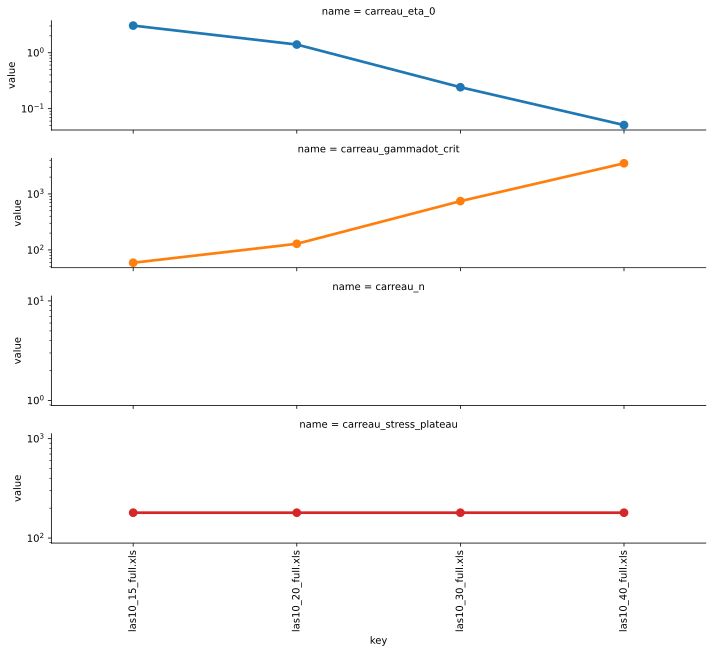

In [35]:
g = sns.catplot(x="key", y="value",
                hue="name", row="name",
                data=pb.tidy(fit_res_dict_solvent), kind="point",
                dodge=False,
                sharey=False,
                height=2, aspect=5).set_xticklabels(rotation=90).set(yscale="log")